# Making CMIP6 indicators and CMIP6 monthly data CF-compliant

This notebook aims to take the pre-ingest CMIP6 indicators and a subset of pre-ingest CMIP6 monthly datasets and "fix" them to be CF-compliant. This is a demonstration of the steps required for compliance and shows what a CF-compliant coverage would look like. We also ingest the datasets into Rasdaman (Apollo) and then request them as netCDF to see if the data returned from Rasdaman can be decoded preoperly by `xarray`.

- 📗 Read about CF conventions (in full) here: https://cfconventions.org/cf-conventions/cf-conventions.html

- 📙 Read about CF conventions (abbreviated) here: https://cfconventions.org/cf-conventions/conformance.html
	
- 📘 Read about the `cfchecker` package here: https://github.com/cedadev/cf-checker. The software checks the dataset against CF Version CF-1.8. The current CF version is actually newer (1.13), but this is the most recent version that the software can check against.

- 🪄 Install the `cfchecker` package into an environment that also has the packages imported below (`snap-geo` worked for me).

- 💾 Get a local copy of the pre-ingests datasets from Apollo at `/home/UA/jdpaul3/temp/cmip6_data.zip`. Unzip that ~1.6GB file into the same directory as this notebook. It includes the full indicators dataset (`cmip6_indicators.nc`) that would be created by running the scripts in [this repo](https://github.com/ua-snap/rasdaman-ingest/tree/main/ardac/cmip6_indicators) and is the dataset currently being ingested into production Rasdaman (Zeus). It also includes a directory (`CMIP6_monthly/*`) which contains a subset of the regridded CMIP6 data (2 models, 2 scenarios, 2 variables).

### Setup

In [1]:
import xarray as xr
import rioxarray
import pandas as pd
import requests
import json
import io

# local import
from cf_utils import *

## CMIP6 Indicators

Let's check out the original pre-ingest dataset. This is an example of dataset that has been merged into a single netCDF file, with the variables in the `data_vars` section of the `xr.DataSet` structure.

In [2]:
c6ind_ds = xr.open_dataset("cmip6_indicators.nc")
c6ind_ds

<xarray.Dataset> Size: 3GB
Dimensions:   (lat: 43, lon: 288, year: 251, scenario: 5, model: 11)
Coordinates:
  * lat       (lat) float64 344B 90.0 89.06 88.12 87.17 ... 52.3 51.36 50.42
  * lon       (lon) float64 2kB 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
  * year      (year) int32 1kB 1850 1851 1852 1853 1854 ... 2097 2098 2099 2100
  * scenario  (scenario) <U10 200B 'historical' 'ssp126' ... 'ssp370' 'ssp585'
  * model     (model) <U15 660B 'CESM2' 'CNRM-CM6-1-HR' ... 'TaiESM1'
Data variables:
    dw        (scenario, model, year, lon, lat) int32 684MB ...
    rx1day    (scenario, model, year, lon, lat) float64 1GB ...
    ftc       (scenario, model, year, lon, lat) int32 684MB ...
    su        (scenario, model, year, lon, lat) int32 684MB ...

Does this pass the `cfchecker`?

In [3]:
!cfchecks cmip6_indicators.nc

CHECKING NetCDF FILE: cmip6_indicators.nc
Using CF Checker Version 4.1.0
Checking against CF Version CF-1.8
Using Standard Name Table Version 90 (2025-03-20T01:16:14Z)
Using Area Type Table Version 13 (20 March 2025)
Using Standardized Region Name Table Version 5 (12 November 2024)

WARN: (2.6.1): No 'Conventions' attribute present
ERROR: (7.1): bounds attribute referencing non-existent variable lat_bnds
ERROR: (7.1): bounds attribute referencing non-existent variable lon_bnds

------------------
Checking variable: lat
------------------
INFO: attribute title is being used in a non-standard way

------------------
Checking variable: lon
------------------
INFO: attribute title is being used in a non-standard way

------------------
Checking variable: year
------------------
WARN: (3): No standard_name or long_name attribute specified
WARN: (3.1): units attribute should be present

------------------
Checking variable: scenario
------------------
ERROR: (2.2): Invalid variable type: <cl

Nope. The check function itself actually fails due to the string data type being used in the dimensions. So let's fix that first, so the checker can complete. 

## Non-spatiotemporal dimensions

Per CF conventions, values for all dimensions must be numeric and monotonic. This also applies to "discrete" axes, which do not have coordinate values in the spatiotemporal sense of the term.

For this demo, we can simply use the encodings dictionaries from original ingest's `luts.py` ([here](https://github.com/ua-snap/rasdaman-ingest/blob/main/ardac/cmip6_indicators/luts.py)) to replace the string values with integers. We then include the encodings dictionary as an attribute for that specific dimension.

All dimensions require a units attribute, but dimensions are allowed to be unitless. In this case, we can pass the `cfchecker` by simply using an empty space for the units.

The `cf_utils.map_model_and_scenario_to_int()` and `cf_utils.add_model_and_scenario_encoding_dicts()` functions accomplish all these tasks.

In [4]:
models = {
    "CESM2": 0,
    "CNRM-CM6-1-HR": 1,
    "EC-Earth3-Veg": 2,
    "GFDL-ESM4": 3,
    "HadGEM3-GC31-LL": 4,
    "HadGEM3-GC31-MM": 5,
    "KACE-1-0-G": 6,
    "MIROC6": 7,
    "MPI-ESM1-2-LR": 8,  # had to change this to "-LR" version, to fix typo in original luts.py!
    "MRI-ESM2-0": 9,  # this model did not make it into my pre-ingest dataset for some reason?
    "NorESM2-MM": 10,
    "TaiESM1": 11,
}

scenarios = {"historical": 0, "ssp126": 1, "ssp245": 2, "ssp370": 3, "ssp585": 4}

In [5]:
c6ind_ds = map_model_and_scenario_to_int(c6ind_ds, models, scenarios)
c6ind_ds = add_model_and_scenario_encoding_dicts(c6ind_ds, models, scenarios)
c6ind_ds

<xarray.Dataset> Size: 3GB
Dimensions:   (lat: 43, lon: 288, year: 251, scenario: 5, model: 11)
Coordinates:
  * lat       (lat) float64 344B 90.0 89.06 88.12 87.17 ... 52.3 51.36 50.42
  * lon       (lon) float64 2kB 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
  * year      (year) int32 1kB 1850 1851 1852 1853 1854 ... 2097 2098 2099 2100
  * scenario  (scenario) int64 40B 0 1 2 3 4
  * model     (model) int64 88B 0 1 2 3 4 5 6 7 8 10 11
Data variables:
    dw        (scenario, model, year, lon, lat) int32 684MB ...
    rx1day    (scenario, model, year, lon, lat) float64 1GB ...
    ftc       (scenario, model, year, lon, lat) int32 684MB ...
    su        (scenario, model, year, lon, lat) int32 684MB ...

Let's save this file and run the `cfchecker` again so it completes.

In [6]:
c6ind_ds.to_netcdf("cmip6_indicators_1.nc")
!cfchecks cmip6_indicators_1.nc

CHECKING NetCDF FILE: cmip6_indicators_1.nc
Using CF Checker Version 4.1.0
Checking against CF Version CF-1.8
Using Standard Name Table Version 90 (2025-03-20T01:16:14Z)
Using Area Type Table Version 13 (20 March 2025)
Using Standardized Region Name Table Version 5 (12 November 2024)

WARN: (2.6.1): No 'Conventions' attribute present
ERROR: (7.1): bounds attribute referencing non-existent variable lat_bnds
ERROR: (7.1): bounds attribute referencing non-existent variable lon_bnds

------------------
Checking variable: lat
------------------
INFO: attribute title is being used in a non-standard way

------------------
Checking variable: lon
------------------
INFO: attribute title is being used in a non-standard way

------------------
Checking variable: year
------------------
WARN: (3): No standard_name or long_name attribute specified
WARN: (3.1): units attribute should be present

------------------
Checking variable: dw
------------------
WARN: (2.4): space/time dimensions appear in

Now that we have the full report from the CF checker, let's delete that file we just saved and continue to address the issues.

In [7]:
!rm cmip6_indicators_1.nc

## Spatiotemporal Dimensions + Variables

It is helpful here to establish some metadata dictionaries that we will use in the CF compliance functions.

In [8]:
global_attributes = {
    "attributes": {
        "Conventions": "CF-1.8",
        "Title": "CMIP6 Indicators",
        "Author": "Scenarios Network for Alaska and Arctic Planning (SNAP)",
        "Institution": "International Arctic Research Center, University of Alaska Fairbanks",
        "URL": "https://www.snap.uaf.edu",
        "Email": "uaf-snap-data-tools@alaska.edu",
    },
    "crs": "EPSG:4326",
    "start_date": "1850-01-01",
}

var_info = {
    "dw": {
        "long_name": "Deep Winter Days",
        "units": "d",
        "description": "Annual number of days with minimum 2 m air temperature < -30 degc.",
        "data_type": "int16",
        "_FillValue": -9999,
    },
    "rx1day": {
        "long_name": "Maximum 1-day Precipitation",
        "units": "mm",
        "description": "Annual maximum 1-day precipitation amount.",
        "data_type": "int16",
        "_FillValue": -9999,
    },
    "su": {
        "long_name": "Summer Days",
        "units": "d",
        "description": "Annual number of days with maximum 2 m air temperature > 25 degc.",
        "data_type": "int16",
        "_FillValue": -9999,
    },
    "ftc": {
        "long_name": "Freeze-Thaw Cycle Days",
        "units": "d",
        "description": "Annual number of days with a diurnal freeze-thaw cycle, where maximum daily 2 m air temperatures are above 0 degc and minimum daily 2 m air temperatures are at or below 0 degc.",
        "data_type": "int16",
        "_FillValue": -9999,
    },
}

### Time

To meet CF conventions, the time dimension has to be:
- named _"time"_ or _"T"_
- be integer data type, increasing monotonically
- be in the formats _"days since..."_, _"seconds since..."_, etc.
    - **NOTE:** CF conventions strongly recommend against using "months" or "years" since months and years are not well-defined units (i.e., some months are longer than others, some years are longer than others / may be defined as 365.25 days, etc.)


For this dataset, the `years` dimension has info for years between 1850 and 2100. We want to rename this dimension `time` and convert the values to integer `days since 1850-01-01`. We then add metadata attributes to that dimension that define the units.

We don't have a universal function for this yet, since there is a ton of variety in the way we encode `time`. So below is a custom "fix" for this specific dataset that has integer years in a dimension named `year`.

In [9]:
# convert strings to datetime
days = [
    pd.Timestamp(f"{year}-01-01").toordinal()
    - pd.Timestamp(global_attributes["start_date"]).toordinal()
    for year in c6ind_ds["year"].values
]

# reassign the coordinate values
c6ind_ds = c6ind_ds.assign_coords({"year": ("year", days)})

# rename the dimension
c6ind_ds = c6ind_ds.rename({"year": "time"})

# add metadata
c6ind_ds["time"].attrs["units"] = f"days since {global_attributes['start_date']} 0:0:0"
# including calendar attribute
c6ind_ds["time"].attrs["calendar"] = "standard"
# CF name attributes
c6ind_ds["time"].attrs["standard_name"] = "time"
c6ind_ds["time"].attrs["long_name"] = "time"
# axis attribute
c6ind_ds["time"].attrs["axis"] = "T"

# include min_value and max_value attributes derived from the data
# this is distinct from the valid_min and valid_max attributes,
# which are the full range of values allowed by the datatype
c6ind_ds["time"].attrs["min_value"] = c6ind_ds["time"].min().values
c6ind_ds["time"].attrs["max_value"] = c6ind_ds["time"].max().values

In [10]:
c6ind_ds

<xarray.Dataset> Size: 3GB
Dimensions:   (lat: 43, lon: 288, scenario: 5, model: 11, time: 251)
Coordinates:
  * lat       (lat) float64 344B 90.0 89.06 88.12 87.17 ... 52.3 51.36 50.42
  * lon       (lon) float64 2kB 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
  * scenario  (scenario) int64 40B 0 1 2 3 4
  * model     (model) int64 88B 0 1 2 3 4 5 6 7 8 10 11
  * time      (time) int64 2kB 0 365 730 1096 1461 ... 90216 90581 90946 91311
Data variables:
    dw        (scenario, model, time, lon, lat) int32 684MB ...
    rx1day    (scenario, model, time, lon, lat) float64 1GB ...
    ftc       (scenario, model, time, lon, lat) int32 684MB ...
    su        (scenario, model, time, lon, lat) int32 684MB ...

### lat and lon

In this dataset, it looks like a bunch of attributes were inherited from previous datasets in the processing pipeline, and are no longer accurate. So first we will just drop the attributes and start over.

CF conventions require names, axes, and units to be defined for `lat` and `lon` dimensions.

Our input data has longitude in a range 0 to 360 degrees east. This is technically allowed by CF conventions (see [here](https://github.com/cf-convention/cf-conventions/issues/435)), but we want to convert the longitude to -180 to 180 because it is the format our coordinate queries will be in. Since this will cause the order of the values to be non-monotonic, we also have to sort that dimension.

In [11]:
# convert longitudes to range -180 to 180
c6ind_ds["lon"] = c6ind_ds["lon"].where(c6ind_ds["lon"] <= 180, c6ind_ds["lon"] - 360)
# and sort the longtitudes to make them monotonic
c6ind_ds = c6ind_ds.sortby("lon")

c6ind_ds = refresh_lat_lon_metadata(c6ind_ds)
c6ind_ds

<xarray.Dataset> Size: 3GB
Dimensions:   (lat: 43, lon: 288, scenario: 5, model: 11, time: 251)
Coordinates:
  * lat       (lat) float64 344B 90.0 89.06 88.12 87.17 ... 52.3 51.36 50.42
  * lon       (lon) float64 2kB -178.8 -177.5 -176.2 ... 177.5 178.8 180.0
  * scenario  (scenario) int64 40B 0 1 2 3 4
  * model     (model) int64 88B 0 1 2 3 4 5 6 7 8 10 11
  * time      (time) int64 2kB 0 365 730 1096 1461 ... 90216 90581 90946 91311
Data variables:
    dw        (scenario, model, time, lon, lat) int32 684MB ...
    rx1day    (scenario, model, time, lon, lat) float64 1GB ...
    ftc       (scenario, model, time, lon, lat) int32 684MB ...
    su        (scenario, model, time, lon, lat) int32 684MB ...

### Variables

Like the `lat` and `lon` dimensions, it looks like a bunch of attributes were inherited from previous datasets in the processing pipeline. So again we will just drop the attributes and start over. 

We will add units, names, and descriptions to the attributes, and nodata values to the variable encoding.

CF conventions also recommend that spatiotemporal dimensions be listed in the order `T` (time), `Z` (height), `Y` (latitude), and `X` (longitude), so we will transpose the variables so that the data is reshaped with the `time`, `lat`, and `lon` dimensions in that order. The non-spatiotemporal dimensions should be "to the left", i.e. listed before the spatiotemporal dimensions. So we will use the order `model`, `scenario`, `time`, `lat`, `lon`.

We are also going to convert all values to 16 bit integers, since the `dw`, `su`, and `ftc` values will always be between -9999 and 365. We can convert the `rx1day` values to integers, because we really don't need sub-millimeter precision here; these values should fall between -9999 and 1000. This has nothing to do with CF conventions, but is good practice to reduce size on disk!

In [12]:
c6ind_ds = refresh_variable_metadata_and_enforce_dtype(c6ind_ds, var_info)
c6ind_ds = transpose_dims(c6ind_ds)

c6ind_ds

/Users/joshpaul/miniconda3/envs/snap-geo/lib/python3.11/site-packages/xarray/core/duck_array_ops.py:215: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)


<xarray.Dataset> Size: 1GB
Dimensions:   (lat: 43, lon: 288, scenario: 5, model: 11, time: 251)
Coordinates:
  * lat       (lat) float64 344B 90.0 89.06 88.12 87.17 ... 52.3 51.36 50.42
  * lon       (lon) float64 2kB -178.8 -177.5 -176.2 ... 177.5 178.8 180.0
  * scenario  (scenario) int64 40B 0 1 2 3 4
  * model     (model) int64 88B 0 1 2 3 4 5 6 7 8 10 11
  * time      (time) int64 2kB 0 365 730 1096 1461 ... 90216 90581 90946 91311
Data variables:
    dw        (model, scenario, time, lat, lon) int16 342MB -9999 -9999 ... 0 0
    rx1day    (model, scenario, time, lat, lon) int16 342MB 5 5 5 5 ... 55 64 56
    ftc       (model, scenario, time, lat, lon) int16 342MB -9999 -9999 ... 0 0
    su        (model, scenario, time, lat, lon) int16 342MB -9999 -9999 ... 0 0

## Global attributes

Besides the `Conventions` attribute, here we have free reign to describe the dataset and add any other useful metadata. Since all the encodings, units, and descriptions are now in the dimension and variable metadata attributes, we can save the global attributes for higher level information.

The CRS is somewhat unique in that writing a CRS to the dataset causes the information to end up as a coordinate or dimension. We would probably consider this a global variable, but in fact there are cases where datasets can have multiple CRS defined, so this information actually becomes a coordinate.

In [13]:
c6ind_ds = add_global_attrs(c6ind_ds, global_attributes)
c6ind_ds = add_crs(c6ind_ds, global_attributes["crs"])

c6ind_ds

<xarray.Dataset> Size: 1GB
Dimensions:      (lat: 43, lon: 288, model: 11, scenario: 5, time: 251)
Coordinates:
  * lat          (lat) float64 344B 90.0 89.06 88.12 87.17 ... 52.3 51.36 50.42
  * lon          (lon) float64 2kB -178.8 -177.5 -176.2 ... 177.5 178.8 180.0
  * scenario     (scenario) int64 40B 0 1 2 3 4
  * model        (model) int64 88B 0 1 2 3 4 5 6 7 8 10 11
  * time         (time) int64 2kB 0 365 730 1096 ... 90216 90581 90946 91311
    spatial_ref  int64 8B 0
Data variables:
    dw           (model, scenario, time, lat, lon) int16 342MB -9999 -9999 ... 0
    rx1day       (model, scenario, time, lat, lon) int16 342MB 5 5 5 ... 64 56
    ftc          (model, scenario, time, lat, lon) int16 342MB -9999 -9999 ... 0
    su           (model, scenario, time, lat, lon) int16 342MB -9999 -9999 ... 0
Attributes:
    Conventions:  CF-1.8
    Title:        CMIP6 Indicators
    Author:       Scenarios Network for Alaska and Arctic Planning (SNAP)
    Institution:  International Arctic Research Center, University of Alaska ...
    URL:          https://www.snap.uaf.edu
    Email:        uaf-snap-data-tools@alaska.edu

## Save and test decoding

What happens when we save this revised dataset, and then run the `cfchecker`?

What happens when we tell `xarray` to decode using CF conventions?

In [14]:
c6ind_ds.to_netcdf("cmip6_indicators_cftest.nc")
!cfchecks cmip6_indicators_cftest.nc

CHECKING NetCDF FILE: cmip6_indicators_cftest.nc
Using CF Checker Version 4.1.0
Checking against CF Version CF-1.8
Using Standard Name Table Version 90 (2025-03-20T01:16:14Z)
Using Area Type Table Version 13 (20 March 2025)
Using Standardized Region Name Table Version 5 (12 November 2024)


------------------
Checking variable: lat
------------------

------------------
Checking variable: lon
------------------

------------------
Checking variable: dw
------------------

------------------
Checking variable: rx1day
------------------

------------------
Checking variable: ftc
------------------

------------------
Checking variable: su
------------------

------------------
Checking variable: scenario
------------------

------------------
Checking variable: model
------------------

------------------
Checking variable: time
------------------

------------------
Checking variable: spatial_ref
------------------
INFO: (5.6): CF checker currently does not verify the syntax of the crs_

We get a warning telling us that we should probably validate the WKT text, but since we set this with `rioxarray` it should be fine.

Opening the file using the `decode_cf=True` and `decode_coords-"all"` flags shows that `xarray` and `rioxarray` can successfully decode the file.

The time dimension of the file is automatically converted to `datetime64[ns]` data type, all other original data types are honored, and the `_FillValue`s for each variable are now accessible in the variable attributes.

We can see that `rioxarray` automatically detects the CRS and can plot the data where it should be.

Note that we need to pass `mask_and_scale=False` to avoid `xarray` converting all variables to floats during decoding (see [here](https://stackoverflow.com/questions/68460507/xarray-loading-int-data-as-float) for a brief explanation of this behavior.)

In [15]:
ds_loaded_cf = xr.open_dataset(
    "cmip6_indicators_cftest.nc",
    decode_cf=True,
    decode_coords="all",
    mask_and_scale=False,
)
ds_loaded_cf

<xarray.Dataset> Size: 1GB
Dimensions:      (lat: 43, lon: 288, model: 11, scenario: 5, time: 251)
Coordinates:
  * lat          (lat) float64 344B 90.0 89.06 88.12 87.17 ... 52.3 51.36 50.42
  * lon          (lon) float64 2kB -178.8 -177.5 -176.2 ... 177.5 178.8 180.0
  * scenario     (scenario) int64 40B 0 1 2 3 4
  * model        (model) int64 88B 0 1 2 3 4 5 6 7 8 10 11
  * time         (time) datetime64[ns] 2kB 1850-01-01 1851-01-01 ... 2100-01-01
    spatial_ref  int64 8B ...
Data variables:
    dw           (model, scenario, time, lat, lon) int16 342MB ...
    rx1day       (model, scenario, time, lat, lon) int16 342MB ...
    ftc          (model, scenario, time, lat, lon) int16 342MB ...
    su           (model, scenario, time, lat, lon) int16 342MB ...
Attributes:
    Conventions:  CF-1.8
    Title:        CMIP6 Indicators
    Author:       Scenarios Network for Alaska and Arctic Planning (SNAP)
    Institution:  International Arctic Research Center, University of Alaska ...
    URL:          https://www.snap.uaf.edu
    Email:        uaf-snap-data-tools@alaska.edu

In [16]:
ds_loaded_cf.rio.crs

CRS.from_epsg(4326)

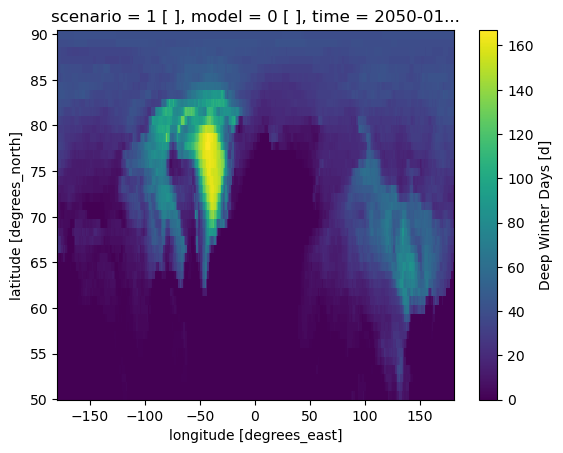

In [17]:
ds_loaded_cf["dw"].sel(time="2050-01-01T00:00:00.000000000", model=0, scenario=1).plot()

What is the size on disk difference between the original and revised datasets? (This is due to changing the data types to `int16`.)

In [18]:
# get file size in GB
!du -h cmip6_indicators.nc
!du -h cmip6_indicators_cftest.nc

3.2G	cmip6_indicators.nc
1.3G	cmip6_indicators_cftest.nc


## Rasdaman ingest & test

Ingest the data to Apollo using `ingest_indicators_cf.json`. (You may want to revise the name of the coverage in the ingest for testing purposes.) Note that this ingest does not require a `luts.py` file; all metadata is derived from the netCDF directly!

```
/opt/rasdaman/bin/wcst_import.sh -c 0 ingest_cf.json
```

Checking out the decribe coverage request, we see all the metadata from global and variable attributes make it into Rasdaman:
http://apollo.snap.uaf.edu:8080/rasdaman/ows?&SERVICE=WCS&VERSION=2.1.0&REQUEST=DescribeCoverage&COVERAGEID=cmip6_indicators_cf&outputType=GeneralGridCoverage

Let's request one variable at the Fairbanks area in netCDF format. Let's see if the netCDF returned by Rasdaman can be decoded by `xarray` in the same way as the file we ingested.

In [19]:
coverage_id = "cmip6_indicators_cf"
var_id = "dw"
lat_1 = 64.8
lat_2 = 65.3
lon_1 = -149.3
lon_2 = -147.7

get_netcdf_url = f"http://apollo.snap.uaf.edu:8080/rasdaman/ows?&SERVICE=WCS&VERSION=2.0.1&REQUEST=GetCoverage&COVERAGEID={coverage_id}&SUBSET=lat({lat_1},{lat_2})&SUBSET=lon({lon_1},{lon_2})&RANGESUBSET={var_id}&FORMAT=application/netcdf"

In [20]:
with requests.get(get_netcdf_url) as response:
    if response.status_code == 200:
        print("Request OK")
        # open as xarray dataset
        ras_ds = xr.open_dataset(
            io.BytesIO(response.content),
            decode_cf=True,
            decode_coords="all",
            mask_and_scale=False,
        )
    else:
        print("Request failed")
        print(response.status_code)
        print(response.text)

Request OK


The dataset below looks almost identical to the one we loaded from disk, except that we have a new `crs()` dimension which is essentially the same as `spatial_ref()`, which has been moved to the data vars section. CF conventions allow either name to be used, so I guess this works out.

The `time` decoding worked fine, and all of the coordinate and variable attributes appear to be correct. The global file metadata appears because we set `"global": "auto"` in the ingest.

What is different? It looks like Rasdaman adds a `valid_min` and `valid_max` to the variable attributes, which is essentially the full range of possible values for the `int16` data type. That's OK, as long as we don't get these attributes confused with `min_value` and `max_value` that could be used for validation purposes. Rasdaman also converts the model and scenario data types to floats, which doesn't exactly match the encodings dictionary we included as attributes for those dimensions. Otherwise, this looks pretty good.

In [21]:
ras_ds

<xarray.Dataset> Size: 113kB
Dimensions:      (model: 11, scenario: 5, time: 251, lat: 2, lon: 2)
Coordinates:
    crs          |S1 1B ...
  * model        (model) float64 88B 0.0 1.0 2.0 3.0 4.0 ... 7.0 8.0 10.0 11.0
  * scenario     (scenario) float64 40B 0.0 1.0 2.0 3.0 4.0
  * time         (time) datetime64[ns] 2kB 1850-01-01 1851-01-01 ... 2100-01-01
  * lat          (lat) float64 16B 65.5 64.55
  * lon          (lon) float64 16B -148.8 -147.5
Data variables:
    dw           (model, scenario, time, lat, lon) int16 110kB ...
    spatial_ref  int32 4B ...
Attributes:
    Author:       Scenarios Network for Alaska and Arctic Planning (SNAP)
    Conventions:  CF-1.8
    Email:        uaf-snap-data-tools@alaska.edu
    Institution:  International Arctic Research Center, University of Alaska ...
    Title:        CMIP6 Indicators
    URL:          https://www.snap.uaf.edu

In [22]:
ras_ds.rio.crs

CRS.from_epsg(4326)

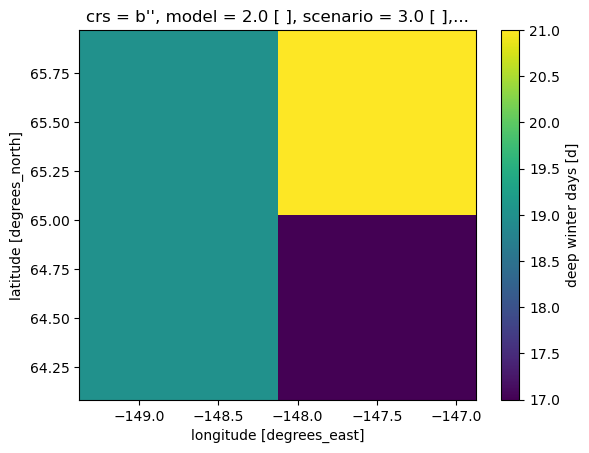

In [23]:
ras_ds["dw"].sel(time="2050-01-01T00:00:00.000000000", model=2, scenario=3).plot()

## CMIP6 monthly

Coming soon....